In [3]:
import pandas as pd
import numpy as np

import sklearn.cross_validation

import skimage.exposure
import skimage.transform

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [4]:
# Read training set info and make train/val split
np.random.seed(42)

df = pd.read_csv('../data/train.csv')

N_CLASSES = len(df.whaleID.unique())
CLASS_IX = {ID: i for i, ID in enumerate(df.whaleID.unique())}

train_ix, val_ix = sklearn.cross_validation.train_test_split(range(len(df)))

In [5]:
# function to load and preprocess image with random distortions

# expects input images cropped to face region, 384x384  
DATA_DIR = '../data/traincrops'

def prep_image(fn, seed=None):
    if seed is None:
        seed = np.random.randint(4294967295)
    rng = np.random.RandomState(seed)

    im = plt.imread('{}/{}'.format(DATA_DIR, fn))
    
    # scale cropped region to square 384x384
    im = skimage.transform.resize(im, (384, 384))

    # random adjustment of gamma
    im = skimage.exposure.adjust_gamma(im, rng.uniform(0.5, 1.5))

    # random crop of each border
    x1, x2, y1, y2 = rng.randint(1, 48, 4)
    im = im[y1:-y2, x1:-x2]
    
    # scale cropped region to square 320x320
    im = skimage.transform.resize(im, (320, 320))
    
    im = im - 0.5

    # convert axes to bc01
    im = np.transpose(im, (2, 0, 1))[np.newaxis]

    return lasagne.utils.floatX(im)

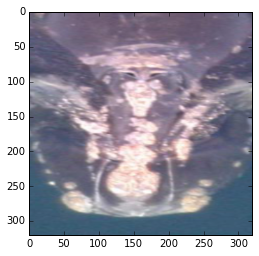

In [6]:
im = prep_image(df.ix[0, 0])
plt.imshow(im[0].T + 0.5)

In [5]:
# generate a minibatch of augmented images and labels

def batch(ix, batch_size, seed=None):
    if seed is None:
        seed = np.random.randint(4294967295)
    rng = np.random.RandomState(seed)
    seeds = rng.randint(0, 4294967295, batch_size)
    
    image_ix = rng.choice(ix, batch_size)
    fns = (df.ix[i].Image for i in image_ix)
    images = [prep_image(fn, seed) for fn, seed in zip(fns, seeds)]
    images = np.concatenate(images)
    
    labels = np.array([CLASS_IX[df.whaleID[i]] for i in image_ix]).astype('int32')
    return images, labels

In [6]:
# Context manager to generate batches in the background via a process pool

import uuid, os, pickle
from multiprocessing import Process, Queue

class BatchGenCM:
    def __init__(self, batch_fn, ix, batch_size, seed=None, num_workers=8):
        self.batch_fn = batch_fn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.ix = ix
        if seed is None:
            seed = np.random.randint(4294967295)
        self.rng = np.random.RandomState(seed)

    def __enter__(self):
        self.jobq = Queue(maxsize=self.num_workers)
        self.doneq = Queue()
        self.processes = []
        
        def f(batch_fn, ix, batch_size, seed, jobq, doneq):
            rng = np.random.RandomState(seed)
            while True:
                n = jobq.get()
                if n is None:
                    break
                seed = rng.randint(4294967295)
                batch = batch_fn(ix, batch_size, seed)
                pickle.dump(batch, open('/run/shm/{}'.format(n), 'w'), protocol=pickle.HIGHEST_PROTOCOL)
                doneq.put(n)
        
        for _ in range(self.num_workers):
            n = str(uuid.uuid4())
            self.jobq.put(n)

            seed = self.rng.randint(4294967295)
            p = Process(target=f, args=(self.batch_fn, self.ix, self.batch_size, seed, self.jobq, self.doneq))
            self.processes.append(p)
            p.start()        

        return self
    
    def __iter__(self):
        return self
    
    def next(self):
        n = self.doneq.get()
        batch = pickle.load(open('/run/shm/{}'.format(n)))
        os.system('rm /run/shm/{}'.format(n))

        n = str(uuid.uuid4())
        self.jobq.put(n)        
        return batch
            
    def __exit__(self, exc_type, exc_value, traceback):
        for _ in range(self.num_workers):
            self.jobq.put(None)
        for process in self.processes:
            process.join()
        while not self.doneq.empty():
            _ = next(self)

In [7]:
# Neon's dropout works a bit differently than Lasagne, matching it just in case it matters

from lasagne.layers import Layer
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from lasagne.random import get_rng

class NeonDropoutLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(NeonDropoutLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return (1 - self.p) * input
        else:
            retain_prob = 1 - self.p

            # use nonsymbolic shape for dropout mask if possible
            input_shape = self.input_shape
            if any(s is None for s in input_shape):
                input_shape = input.shape

            return input * self._srng.binomial(input_shape, p=retain_prob,
                                               dtype=theano.config.floatX)

In [8]:
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool

#from lasagne.layers import Conv2DLayer as Conv
#from lasagne.layers import Pool2DLayer as Pool

from lasagne.layers import batch_norm

from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform
from lasagne.utils import floatX

def build_model(batch_size, input_width, input_height):
    net = {}
    activation = lasagne.nonlinearities.rectify

    nfilt = 32

    l = InputLayer((batch_size, 3, input_width, input_height))
    net['input'] = l
    l = batch_norm(Conv(l, nfilt, 3, stride=2, nonlinearity=rectify, W=GlorotUniform(gain='relu')))

    for _ in range(5):
        if nfilt >= 512:
            nfilt = 512
        l = batch_norm(Conv(l, nfilt, 3, stride=1, pad=1, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
        l = batch_norm(Conv(l, nfilt, 3, stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
        l = Pool(l, 2, stride=2)
        nfilt *= 2
    l = batch_norm(Conv(l, nfilt, 3,stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
        
    l = NeonDropoutLayer(l, p=0.8)
    l = DenseLayer(l, num_units=447, nonlinearity=softmax, W=GlorotUniform(gain='relu'))
    net['output'] = l
    return net

In [9]:
net = build_model(32, 320, 320)

In [10]:
layers = lasagne.layers.get_all_layers(net['output'])
[l.output_shape for l in layers]

[(32, 3, 320, 320),
 (32, 32, 159, 159),
 (32, 32, 159, 159),
 (32, 32, 159, 159),
 (32, 32, 159, 159),
 (32, 32, 159, 159),
 (32, 32, 159, 159),
 (32, 32, 157, 157),
 (32, 32, 157, 157),
 (32, 32, 157, 157),
 (32, 32, 78, 78),
 (32, 64, 78, 78),
 (32, 64, 78, 78),
 (32, 64, 78, 78),
 (32, 64, 76, 76),
 (32, 64, 76, 76),
 (32, 64, 76, 76),
 (32, 64, 38, 38),
 (32, 128, 38, 38),
 (32, 128, 38, 38),
 (32, 128, 38, 38),
 (32, 128, 36, 36),
 (32, 128, 36, 36),
 (32, 128, 36, 36),
 (32, 128, 18, 18),
 (32, 256, 18, 18),
 (32, 256, 18, 18),
 (32, 256, 18, 18),
 (32, 256, 16, 16),
 (32, 256, 16, 16),
 (32, 256, 16, 16),
 (32, 256, 8, 8),
 (32, 512, 8, 8),
 (32, 512, 8, 8),
 (32, 512, 8, 8),
 (32, 512, 6, 6),
 (32, 512, 6, 6),
 (32, 512, 6, 6),
 (32, 512, 3, 3),
 (32, 1024, 1, 1),
 (32, 1024, 1, 1),
 (32, 1024, 1, 1),
 (32, 1024, 1, 1),
 (32, 447)]

In [11]:
X = T.tensor4()
y = T.ivector()

prob = lasagne.layers.get_output(net['output'], X)
loss = T.mean(lasagne.objectives.categorical_crossentropy(prob, y))
acc = T.mean(lasagne.objectives.categorical_accuracy(prob, y))

test_prob = lasagne.layers.get_output(net['output'], X, deterministic=True)
test_loss = T.mean(lasagne.objectives.categorical_crossentropy(test_prob, y))
test_acc = T.mean(lasagne.objectives.categorical_accuracy(test_prob, y))

params = lasagne.layers.get_all_params(net['output'], trainable=True)

updates = lasagne.updates.adadelta(loss, params, learning_rate=1.0, rho=0.9)

In [12]:
f_prob = theano.function([X], test_prob)
f_train = theano.function([X, y], [loss, acc], updates=updates)
f_val = theano.function([X, y], [test_loss, test_acc])

In [44]:
BATCH_SIZE = 32
N_BATCH = len(train_ix) / BATCH_SIZE
N_VAL_BATCH = 10

with BatchGenCM(batch, train_ix, 32) as train_bg, BatchGenCM(batch, val_ix, 32) as val_bg:
    for epoch in range(300):
        loss_train = 0
        for _ in range(N_BATCH):
            loss_batch, _ = f_train(*next(train_bg))
            loss_train += loss_batch
        loss_val = 0
        acc_val = 0
        for _ in range(N_VAL_BATCH):
            loss_batch, acc_batch = f_val(*next(val_bg))
            loss_val += loss_batch
            acc_val += acc_batch
        print('epoch {:03} - tr: {:.04f}, val: {:.04f}, acc {:.04f}'.format(
                epoch, loss_train/N_BATCH, loss_val/N_VAL_BATCH, acc_val/N_VAL_BATCH))

epoch 000 - tr: 0.3880, val: 2.7615, acc 0.5000
epoch 001 - tr: 0.3919, val: 2.7493, acc 0.5031
epoch 002 - tr: 0.3406, val: 2.7089, acc 0.5188
epoch 003 - tr: 0.3259, val: 2.7702, acc 0.4938
epoch 004 - tr: 0.2884, val: 2.5432, acc 0.5437
epoch 005 - tr: 0.2851, val: 2.3849, acc 0.5781
epoch 006 - tr: 0.2700, val: 2.7072, acc 0.5281
epoch 007 - tr: 0.2419, val: 2.6002, acc 0.5531
epoch 008 - tr: 0.2291, val: 2.7172, acc 0.5219
epoch 009 - tr: 0.2078, val: 2.5475, acc 0.5625
epoch 010 - tr: 0.2231, val: 2.3722, acc 0.5594
epoch 011 - tr: 0.1939, val: 2.3885, acc 0.5625
epoch 012 - tr: 0.1889, val: 2.3973, acc 0.5906
epoch 013 - tr: 0.1707, val: 2.4919, acc 0.5312
epoch 014 - tr: 0.1849, val: 2.3305, acc 0.5719
epoch 015 - tr: 0.1697, val: 2.6667, acc 0.5188
epoch 016 - tr: 0.1694, val: 2.2995, acc 0.6188
epoch 017 - tr: 0.1604, val: 2.4341, acc 0.5563
epoch 018 - tr: 0.1418, val: 2.2858, acc 0.5844
epoch 019 - tr: 0.1406, val: 2.1258, acc 0.6156
epoch 020 - tr: 0.1303, val: 2.6290, acc

Process Process-3341:
Process Process-3339:
Process Process-3345:
Process Process-3344:
Process PoolWorker-3332:
Process Process-3343:
Process Process-3337:
Process Process-3338:
Process Process-3335:
Process Process-3340:
Process Process-3346:
Process Process-3348:
Process Process-3342:
Process Process-3347:
Process Process-3333:
Process Process-3336:
Process Process-3334:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cuda/anaconda2

KeyboardInterrupt: 

  File "/home/cuda/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py", line 291, in img_as_float
KeyboardInterrupt
    return convert(image, np.float64, force_copy)
  File "/home/cuda/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py", line 231, in convert
    np.float32, np.float64))
KeyboardInterrupt


In [45]:
pvs = lasagne.layers.get_all_param_values(net['output'])
with open('./trained_convnet_78_epochs.pkl','w') as f:
    pickle.dump(pvs, f)
f.close()

In [13]:
with open('./trained_convnet_52_epochs.pkl','r') as f:
    pvs = pickle.load(f)
f.close()
lasagne.layers.set_all_param_values(net['output'], pvs)

In [14]:
DATA_DIR = '../data/testcrops'

In [15]:
def prep_test_image(fn, seed):
    rng = np.random.RandomState(seed)
    im = plt.imread('{}/{}'.format(DATA_DIR, fn))
    im = im/255.
    if min(im.shape[:2]) < 384:
        im = skimage.transform.resize(im, (384, 384))
    im = skimage.exposure.adjust_gamma(im, rng.uniform(0.5, 1.5))
    x1, x2, y1, y2 = rng.randint(1, 48, 4)
    im = im[y1:-y2, x1:-x2]
    im = skimage.transform.resize(im, (320, 320))
    
    im = im - 0.5

    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)

    return lasagne.utils.floatX(im[np.newaxis])

In [16]:
import joblib

In [ ]:
df = pd.read_csv('../data/sample_submission.csv')
    
#rng = np.random.RandomState(SEED)

p = []
for i in range(len(df)):
    seeds = np.random.randint(0, 4294967295, 64)
    im = np.concatenate(joblib.Parallel(n_jobs=8)(joblib.delayed(prep_test_image)(df.Image[i], s) for s in seeds))
    p.append(f_prob(im).mean(0))
p = np.array(p)

ix_map = np.array([CLASS_IX[i] for i in df.columns[1:]])
df.ix[:, 1:] = p[:, ix_map]
df.to_csv('submission.csv', index=False)

In [13]:
skimage.exposure.adjust_gamma?